# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal, then you will want to run the above command.

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from datetime import datetime
from sklearn import preprocessing
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Part 1: Data Exploration
### Step 1. Data overview

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


There are missing value in gender and income columns.

In [5]:
# Check for duplicate in customer id
profile.duplicated(subset='id').sum()

0

In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [8]:
# Check for duplicate in offer id
portfolio.duplicated(subset='id').sum()

0

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [12]:
transcript.groupby('person')['event'].value_counts()

person                            event          
0009655768c64bdeb2e877511632db8f  transaction         8
                                  offer received      5
                                  offer viewed        4
                                  offer completed     3
00116118485d4dfda04fdbaba9a87b5c  transaction         3
                                  offer received      2
                                  offer viewed        2
0011e0d4e6b944f998e987f904e8c1e5  offer received      5
                                  offer viewed        5
                                  transaction         5
                                  offer completed     3
0020c2b971eb4e9188eac86d93036a77  transaction         8
                                  offer received      5
                                  offer completed     3
                                  offer viewed        3
0020ccbbb6d84e358d3414a3ff76cffd  transaction        12
                                  offer received      

In [13]:
transcript[transcript['person']=='0009655768c64bdeb2e877511632db8f'].sort_values('time')

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


- Only offer_id that has 'offer completed' and 'offer viewed' event is offer that actually works
- Transaction that has the same time as 'offer completed' event is the transaction done with offer
- I will restructure transaction table to has each row is an unique combination of (person, offer_id), for offer that doesn't have 'offer completed' event, the transaction amount is 0.
- In this project, I will not dig into time variable, this feature might be analyzed more detail in another analysis.

### Step 2. Data Cleaning
1. profile
 - Impute null value for income column and gender column
 - Convert become_member_on to date type and calculate month_since_member
 - Dummy variables for Gender column
2. portfolio
 - Dummy variables for channels column
 - Dummy variables for order_type column
3. transcript
 - Restructure table to has each row is an unique combination of (person, offer_id)
 - Join restructed transcript table with porfolio and profile table to have full information

#### 1. profile

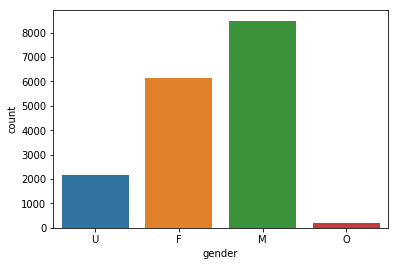

In [14]:
# for gender, let's see how the value distribute
# first, fill null value with 'U' stand for undefined
profile['gender'].fillna('U', inplace=True)
ax = sns.countplot(x="gender", data=profile)

> Since there is no information to guest for null gender, I create a new category 'U' with expectation that this group of customer will has different behavious than other 3 genders.

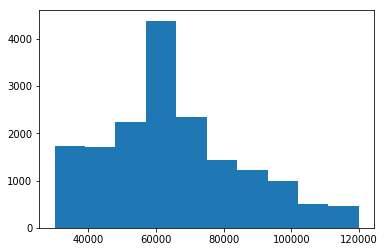

In [15]:
# For income, I will fill nan value with average of this column
profile['income'].fillna(profile['income'].mean(), inplace=True)
plt.hist(profile['income'], bins =10,density=False)
plt.show()

> We can see that most of income fall in the range of $60000

In [16]:
# Convert became_member_on to month_since_member

currentdate = datetime.now()
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y/%m/%d')
profile['month_since_member']=((currentdate - profile['became_member_on'])/np.timedelta64(1, 'M')).astype(int)
# drop became_member_on column
profile.drop(columns='became_member_on', inplace=True)

In [17]:
profile['month_since_member'].unique()

array([628])

This variable only has 1 value, so I will not use in my model. I will drop it

In [18]:
profile.drop(columns='month_since_member', inplace=True)

In [19]:
# rename id column to customer_id
profile.rename(columns={'id':'customer_id'}, inplace=True)

In [20]:
profile.head()

,age,gender,customer_id,income
0,118,U,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,U,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,U,a03223e636434f42ac4c3df47e8bac43,65404.991568


In [21]:
# Create dummy variables from the gender data.
dummies = pd.DataFrame(pd.get_dummies(profile['gender']))
profile_final = pd.concat([profile,dummies],axis=1)
profile_final.drop(columns='gender',inplace=True)

In [22]:
profile_final.head()

,age,customer_id,income,F,M,O,U
0,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,0,0,1
1,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,1,0,0,0
2,118,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,0,0,0,1
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,1,0,0,0
4,118,a03223e636434f42ac4c3df47e8bac43,65404.991568,0,0,0,1


#### 2. portfolio

In [23]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [24]:
# Get unique value of channels
possible_vals=[]
chan=portfolio['channels']
for i in range(chan.shape[0]):
    for j in range(len(chan[i])):
        if chan[i][j] not in possible_vals:
            possible_vals.append(chan[i][j]) 

In [25]:
def cat(x, val):
    '''
    INPUT: 
    x: a list of different channels
    val: value we are looking for
    OUTPUT:
    return 1 if val in list x, else return 0
    
    '''
    if val in x:
        return '1'
    else:
        return '0'

In [26]:
for i in possible_vals:
    portfolio[i]=portfolio['channels'].apply(lambda x: cat(x, i))

In [27]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [28]:
# rename id to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
# drop channels column
portfolio.drop(columns='channels', inplace=True)

In [29]:
# Create dummy variables from the offer_type data.
dummies = pd.DataFrame(pd.get_dummies(portfolio['offer_type']))
portfolio_final = pd.concat([portfolio,dummies],axis=1)

In [30]:
portfolio_final.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


#### 3. transcript

In [31]:
offer_id=[]
amount=[]
reward=[]
for i in range(transcript.shape[0]):
    value_ls=list(transcript['value'][i].items())
    if transcript['event'][i]=='offer completed':
        offer_id.append(value_ls[0][1])
        amount.append(np.nan)
        reward.append(value_ls[1][1])
    if transcript['event'][i]=='offer received' or transcript['event'][i]=='offer viewed':
        offer_id.append(value_ls[0][1])
        amount.append(np.nan)
        reward.append(np.nan)
    if transcript['event'][i]=='transaction':
        offer_id.append(np.nan)
        amount.append(value_ls[0][1])
        reward.append(np.nan)
transcript['offer_id']=offer_id
transcript['reward']=reward
transcript['amount']=amount

In [32]:
# I'm only interested in customer that received offer to see how they are influenced by that offer
# so that I create pivot table with each person and offer_id is a record, person who is not
# receive any offer will be exclude from dataset.
transcript_offer=pd.pivot_table(transcript, index=['person', 'offer_id'],
                                columns=['event'],values=['time'], 
                                aggfunc=np.mean, fill_value=0).reset_index()
transcript_offer.columns=['customer_id','offer_id','offer completed',
                          'offer received','offer viewed']

In [34]:
transcript_offer.tail()


,customer_id,offer_id,offer completed,offer received,offer viewed
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,276.0,204.0,258.0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,198.0,168.0,174.0
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,458.0,440.0,450.0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,504.0,534.0
63287,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,60.0,0.0,6.0


> Interpretation:
- Records that have offer completed = 0, means that offer_id is not completed
- There is some strange records that has offer viewed < offer completed

Next, since I will not use time of each event, and I only care whether or not that customer use the provided offer, I will keep only offer_completed column and encode 1 for offer has been completed and 0 for offer not complete

In [35]:
# an offer considered as completed when time of offer completed != 0
# and time of offer viewd != 0
offer_completed=[]
for i in range(transcript_offer.shape[0]):
    if transcript_offer['offer completed'][i]!=0.0 and transcript_offer['offer viewed'][i]!=0.0:
        offer_completed.append('1')
    else:
        offer_completed.append('0')
transcript_offer['offer_completed']=offer_completed

In [36]:
transcript_offer.drop(columns=['offer completed','offer received',
                               'offer viewed'], inplace=True)

In [37]:
transcript_offer.head()

,customer_id,offer_id,offer_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


In [38]:
# Get amount for completed offer
transcript_completed=transcript.loc[transcript['event']=='offer completed',
                                    ['person','time','offer_id','reward']]
transcript_trans=transcript.loc[transcript['event']=='transaction',
                                ['person','time','amount']]

In [39]:
transcript_completed.groupby(['person','offer_id'])['time'].count()

person                            offer_id                        
0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5    1
                                  f19421c1d4aa40978ebb69ca19b0e20d    1
                                  fafdcd668e3743c1bb461111dcafc2a4    1
0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7    1
                                  2298d6c36e964ae4a3e7e9706d1fb8c2    1
                                  9b98b8c7a33c4b65b9aebfe6a799e6d9    1
0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0    1
                                  fafdcd668e3743c1bb461111dcafc2a4    2
0020ccbbb6d84e358d3414a3ff76cffd  2298d6c36e964ae4a3e7e9706d1fb8c2    1
                                  9b98b8c7a33c4b65b9aebfe6a799e6d9    1
                                  f19421c1d4aa40978ebb69ca19b0e20d    1
003d66b6608740288d6cc97a6903f4f0  0b1e1539f2cc45b7b9fa7c272da2e1d7    1
                                  fafdcd668e3743c1bb461111dcafc2a4   

There are some transaction that is upon completion of 2 offer, in that case, to calculate amount of each offer completed, I will divide by reward of each offer

In [40]:
transcript_completed_full=transcript_completed.merge(transcript_trans, 
                                                     how='left', 
                                                     on=['person','time']).sort_values(by=['person','time'])

In [41]:
# find offer_id that have the same transaction even then recalculate transaction 
# amount of each offer by reward proportion
same_trans=transcript_completed_full[transcript_completed_full.duplicated(
    subset=['person','time'])][['person','time']]
for p, t in zip(same_trans['person'],same_trans['time']):
    sub_set=transcript_completed_full.loc[(transcript_completed_full['person']==p)&(transcript_completed_full['time']==t)]
    total_prop=sub_set['reward'].sum()
    transcript_completed_full.loc[(transcript_completed_full['person']==p)
                                  &(transcript_completed_full['time']==t),
                                  'amount']=(sub_set['amount']*
                                             sub_set['reward'])/total_prop

In [42]:
transcript_completed_full.columns=['customer_id','time','offer_id','reward','amount']

In [43]:
transcript_completed_full[transcript_completed_full['customer_id']=='ffeaa02452ef451082a0361c3ca62ef5']

,customer_id,time,offer_id,reward,amount
3377,ffeaa02452ef451082a0361c3ca62ef5,84,2906b810c7d4411798c6938adc9daaa5,2.0,25.54
23984,ffeaa02452ef451082a0361c3ca62ef5,540,2906b810c7d4411798c6938adc9daaa5,2.0,16.57
29626,ffeaa02452ef451082a0361c3ca62ef5,612,ae264e3637204a6fb9bb56bc8210ddfd,10.0,20.00


In [44]:
# merge transcript_offer table with amount table
transcript_combn=transcript_offer.merge(transcript_completed_full, how='left', on=['customer_id','offer_id'])

Now, I will merge all table to 1 dataset that contain all info

In [45]:
df=(transcript_combn.merge(profile_final, how='left', on='customer_id')).merge(portfolio_final, how='left', on='offer_id',suffixes=('_trans', '_offer'))

In [46]:
df.head()

,customer_id,offer_id,offer_completed,time,reward_trans,amount,age,income,F,M,...,duration,offer_type,reward_offer,email,mobile,social,web,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,576.0,2.0,10.27,33,72000.0,0,1,...,7,discount,2,1,1,0,1,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,NaN,NaN,NaN,33,72000.0,0,1,...,4,informational,0,1,1,0,1,0,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,NaN,NaN,NaN,33,72000.0,0,1,...,3,informational,0,1,1,1,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,414.0,5.0,8.57,33,72000.0,0,1,...,5,bogo,5,1,1,1,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,528.0,2.0,14.11,33,72000.0,0,1,...,10,discount,2,1,1,1,1,0,1,0


## Part 2: Data Analysis


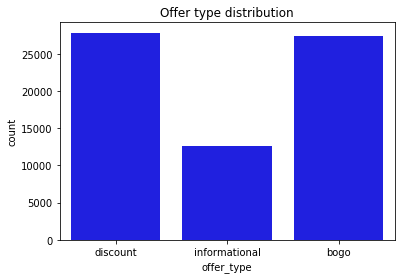

In [47]:
# Let's see the offer_type distribution
# for gender, let's see how the value distribute
# first, fill null value with 'U' stand for undefined
ax = sns.countplot(x="offer_type", data=df, color='blue')
plt.title('Offer type distribution');

We can see that discount and bogo type has the same count in the dataset, which means these types have the same chance to be sent to customer, while informational type has smaller chance.

Next, let's see the relationship between numeric variables. And since they are in different scale, first I will normalize the data

In [48]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
scaler = MinMaxScaler()
df_num=df[['reward_trans','amount','age','income','difficulty','duration','time']].fillna(0)
names = df_num.columns
d = scaler.fit_transform(df_num)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()

,reward_trans,amount,age,income,difficulty,duration,time
0,0.2,0.010111,0.15,0.466667,0.50,0.571429,0.806723
1,0.0,0.000000,0.15,0.466667,0.00,0.142857,0.000000
2,0.0,0.000000,0.15,0.466667,0.00,0.000000,0.000000
3,0.5,0.008437,0.15,0.466667,0.25,0.285714,0.579832
4,0.2,0.013891,0.15,0.466667,0.50,1.000000,0.739496


(7.5, -0.5)

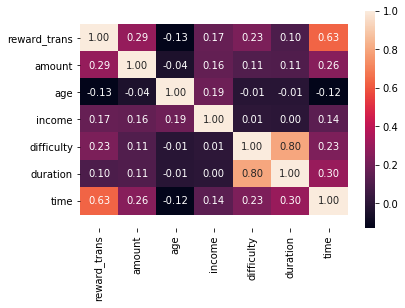

In [49]:
# The relationship between numerical variables

ax=sns.heatmap(scaled_df.corr(),annot=True,fmt='.2f');
# fix issue first and last row cut in half of heatmap plot
bot, top = ax.get_ylim()
ax.set_ylim(bot + 0.5, top - 0.5)

- The strongest relationship is between duration and difficulty.
- Variable that has the strongest correlation with amount is reward.
- Reward and time also have quite strong positive correlation

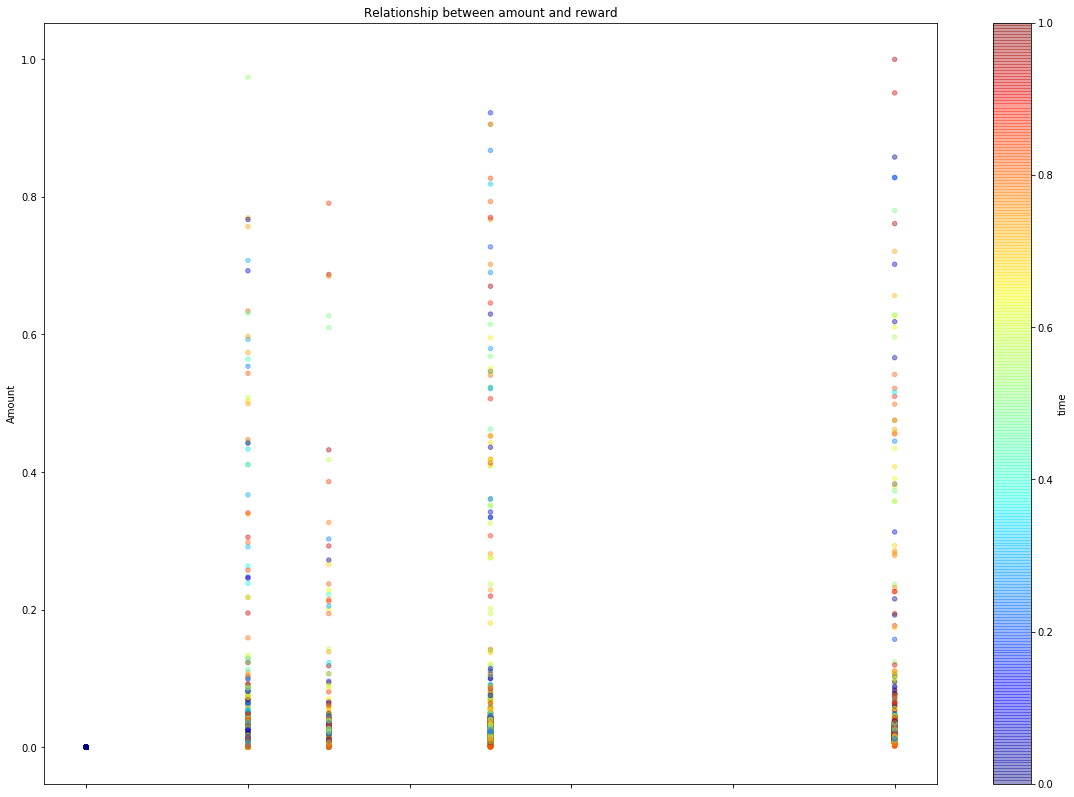

In [50]:
# Let's see relationship between amount and reward to see how offer affect customer
# purchase behaviour
scaled_df.plot(kind="scatter", x="reward_trans", y="amount",
    c="time", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(20,14),
)

plt.title('Relationship between amount and reward')
plt.xlabel('Reward')
plt.ylabel('Amount')
plt.show();

There is no linear relationship here.

## Part 3: Build model

The question that I'm most interested in here is whether a customer will complete an offer that they received. Therefore I will build a classifier to classify customer received offer into 2 groups: complete and not-complete offer

In [51]:
# Before build model, we need 1 more step to clean data
# fillna with 0 for reward_trans and amount
df.fillna(0, inplace=True)

In [52]:
# Drop offer_id column since we already dummy it
df_model=df.drop(columns=['offer_type','customer_id','offer_id'])
df_model.head()

,offer_completed,time,reward_trans,amount,age,income,F,M,O,U,difficulty,duration,reward_offer,email,mobile,social,web,bogo,discount,informational
0,0,576.0,2.0,10.27,33,72000.0,0,1,0,0,10,7,2,1,1,0,1,0,1,0
1,0,0.0,0.0,0.00,33,72000.0,0,1,0,0,0,4,0,1,1,0,1,0,0,1
2,0,0.0,0.0,0.00,33,72000.0,0,1,0,0,0,3,0,1,1,1,0,0,0,1
3,1,414.0,5.0,8.57,33,72000.0,0,1,0,0,5,5,5,1,1,1,1,1,0,0
4,1,528.0,2.0,14.11,33,72000.0,0,1,0,0,10,10,2,1,1,1,1,0,1,0


Now, all variables is in numeric type and ready for model train.

First, let's see for all type of offer, 1 customer will complete the offer or not

In [53]:
X=df_model.iloc[:,1:]
y=df_model.iloc[:,0]

There are many types of classifier that can be used for binary classification, I will compare their evaluation score to get the type that has the best performance


In [54]:
models = {}
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [55]:
def best_model(X,y):
    '''
    This function used to compare performace of all binary classifier by 
    evaluation metric: accuracy, precision, recall
    INPUT:
    - X: independent variables
    - y: dependent variable
    OUTPUT:
    df_metric: DataFrame that has accuracy, precision and recall score of each model.
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)
    accuracy, precision, recall = {}, {}, {}

    for key in models.keys():
    
        # Fit the classifier model
        models[key].fit(X_train, y_train)
    
        # Prediction 
        predictions = models[key].predict(X_test)
    
        # Calculate Accuracy, Precision and Recall Metrics
        accuracy[key] = accuracy_score(predictions, y_test)
        precision[key] = precision_score(predictions, y_test, average="binary", pos_label='1')
        recall[key] = recall_score(predictions, y_test, average="binary", pos_label='1')
    df_metric = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
    df_metric['Accuracy'] = accuracy.values()
    df_metric['Precision'] = precision.values()
    df_metric['Recall'] = recall.values()
    return df_metric

In [56]:
best_model(X,y)

,Accuracy,Precision,Recall
Logistic Regression,0.888177,0.896109,0.842848
Support Vector Machines,0.901068,0.936630,0.841540
Decision Trees,0.894807,0.865584,0.877806
Random Forest,0.916243,0.919850,0.882212
Naive Bayes,0.887661,0.900750,0.838903
K-Nearest Neighbor,0.905930,0.956801,0.838155


When comparing accuracy, precision and recall of each model, random forest is the model that has the best performance, so in following steps, I will use random forest.

In [57]:
def build_model():
    '''
    This function build machine learning pipeline with 1 TRANSFORMER - StandardScaler
    and 1 PREDICTOR - RandomForestClassifier. Then running gridsearch for 2
    params: scaler__with_mean and clf__n_estimators
    
    '''
    pipeline = Pipeline([
       ('scaler', StandardScaler()),
       ('clf', RandomForestClassifier())
    ])

    # specify parameters for grid search
    parameters = {
        'scaler__with_mean': [True, False],
         'clf__n_estimators': [50, 100, 200]
    }

    # create grid search object
    cv = GridSearchCV(pipeline,param_grid=parameters)
    
    return cv

In [58]:
def display_results(cv, y_test, y_pred):
    '''
    Disply result of the model built before (cv)
    INPUT:
    - cv: model built by build_model function
    - y_test: an array of test value
    - y_pred: an array of prected value
    OUTPUT:
    - Labels: All categories that y might fail into
    - Confusion Matrix: Confusion Matrix of y_test and y_pred
    - Accuracy: Accuracy of the model
    - Best Parameters: the parameters that give the best result
    
    '''
    
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

In [59]:
def main(X,y):
    '''
    This function is full flow from create train, test set to build model and 
    display results
    INPUT:
    - X: independent variables
    - y: dependent variable
    OUTPUT:
    Display the result of model trained
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    display_results(model, y_test, y_pred)

In [60]:
main(X,y)

Labels: ['0' '1']
Confusion Matrix:
 [[7191  782]
 [ 285 5317]]
Accuracy: 0.921399631676

Best Parameters: {'clf__n_estimators': 200, 'scaler__with_mean': True}


> With accuracy of 0.921, I'm quite confident that my model can predict correctly whether 1 customer complete the offer when they received.

> Next I will train for dataset of each offer_type to see in each specific type, whether customer complete offer received or not

In [61]:
def load(df,offer_type):
    '''
    This function select the subset of df table base on offer_type
    INPUT:
    - df_model: DataFrame that hold full info of all offer_type
    - offer_type: the type that we are interested in
    OUTPUT:
    X: independent variables of that offer type
    y: dependent variable of that offer type
    
    '''
    df_small=df.loc[df['offer_type']==offer_type]
    df_small=df_small.drop(columns=['offer_type','customer_id','offer_id','bogo','discount','informational'])
    X=df_small.iloc[:,1:]
    y=df_small.iloc[:,0]
    return X,y

In [62]:
# Train model for bogo offer type
X_bogo, y_bogo=load(df,offer_type='bogo')
main(X_bogo, y_bogo)

Labels: ['0' '1']
Confusion Matrix:
 [[2401  364]
 [  92 2624]]
Accuracy: 0.91680350301

Best Parameters: {'clf__n_estimators': 200, 'scaler__with_mean': False}


In [63]:
# Train model for bogo discount type
X_discount, y_discount=load(df,offer_type='discount')
main(X_discount, y_discount)

Labels: ['0' '1']
Confusion Matrix:
 [[2201  445]
 [ 170 2748]]
Accuracy: 0.889468008627

Best Parameters: {'clf__n_estimators': 200, 'scaler__with_mean': True}


> For informational type, there will be no offer_completed event or amount directly related to informational type, I will not build model for that type here.

## Part 4: Conclusion

In above analysis, I have cleaned 3 dataset profile, portfolio and transaction to get a combination dataset that has full information and can be used to build classification model.

When looking into relationship between numerical variable in combination dataset, we can see that
 - The strongest relationship is between duration and difficulty.
 - Variable that has strongest correlation with amount is reward.
 - Reward and time also have quite strong possitive correlation.
This relationship can be used in a prediction model to predict amount that customer might spent.

Lastly, I have built model to predict whether a customer with provided demographic info and offer info will complete the offer that he/she received or not.